# Polygon data - extraction and reduction

In this guide the tools for both extracting and reducing freehand/polygon tool data will be detailed. Freehand/polygon tools are used to identify regions of interest in an image. The various keyword arguments (**kwargs**) will also be explained. This guide is based on a [notebook](https://github.com/zooniverse/aggregation-for-caesar/blob/master/docs/source/Polygon%20data%20-%20extraction%20and%20reduction.ipynb), which you can also download and run yourself.

One of the complications with polygon data is that it is not of the same format: each polygon can have a different number of sides. Therefore deciding what the 'consensus' is for a group of polygons classifying the same region (a 'cluster') of an image can be difficult. A number of different options are presented, and their pros and cons are discussed, so that you can decide what is best for your data. This will be done using simple test data, and is the first topic of the notebook.

We will then apply what we have learnt by investigating a 'realistic' project (you can look forward to some very cute cat photos), with data provided by real volunteers. Both how the extractions and reductions will be done and explained, along with comparing the volunteer's data against the sample images.

This notebook assumes you are already familiar with the idea of clustering. If not, checkout the [How Data Clustering Works](https://aggregation-caesar.zooniverse.org/How_Clustering_Works.html) guide.

As the freehand and polygon tool's output is mathematically the same, both in the rest of this notebook and the extraction/reduction codes, both are referred to as 'polygons'. The freehand tool output is just a polygon with more sides. They are the same for our purposes.

We will need the following packages:

In [1]:
# For aggregation
from panoptes_aggregation.reducers import polygon_reducer_utils as utils
from panoptes_aggregation.reducers import polygon_reducer
from panoptes_aggregation.reducers import polygon_reducer_contours
from panoptes_aggregation.scripts.extract_panoptes_csv import extract_csv
from panoptes_aggregation.scripts.reduce_panoptes_csv import reduce_csv
from io import StringIO

# General
import time
import numpy as np
import shapely
import pandas

# For the plots
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.collections import PatchCollection
from matplotlib import cm, colors, colorbar, colormaps

# To display images
from PIL import Image
import requests
from io import BytesIO

## Simple polygon data

For this section, don't worry too much about the specifics of the code or the format of the data, as we are using `panoptes_aggregation` in an unintended way for illustration purposes with artificial data. Same can be said for the plotting functions. Later it will be shown how the reductions should be done in practice. Instead, focus on how the various kwargs change the aggregated data in the plots.
 
### Construction of artificial data
To start, let's construct a basic cluster of simple regular polygons to use as test data.

A realistic cluster will have a scatter of polygons of different sizes, positions and orientations. Below is code which can be used to make such a cluster. You can image these are the drawings done by volunteers asked to identify a region of interest in an image. Each volunteer will give a slightly different classification.

In [2]:
def area_polygon(num_side):
    # This provides the area relative to an equilateral triangle of the same side length as the polygon
    if num_side == 3:
        return 1
    interior_angle = (num_side - 2) * 180 / num_side
    radian_conversion = np.pi / 180
    height = 0.5 * np.tan(radian_conversion * interior_angle / 2)
    triangle_area = 0.5 * height
    area = num_side * triangle_area
    equilateral_trainge_area = (3**0.5) / 4
    area = area / equilateral_trainge_area
    return area

def polygon_generator(num_side, side_length=1, centre=[0, 0], rotation=0, same_area=True):
    if num_side<3:
        raise ValueError("Need at least 3 sides for a polygon")

    if len(centre)!=2:
        raise ValueError("Centre is a list of 2")

    if same_area==True:
        relative_area = area_polygon(num_side)
        side_length = side_length / (relative_area**0.5)

    # First make a regular polygon of the number of sides provided
    exterior_interior_angle = 360
    radian_conversion = np.pi / 180
    interior_angle = (num_side-2) * 180 / num_side
    angle_change_exteriod = exterior_interior_angle / num_side
    angle = 0
    xs = [0.0]
    ys = [0.0]
    for i in range(1, num_side + 1):
        x_change = float(side_length * np.cos(angle * radian_conversion))
        y_change = float(side_length * np.sin(angle * radian_conversion))
        xs.append(xs[i-1] + x_change)
        ys.append(ys[i-1] + y_change)
        angle += angle_change_exteriod
    old_centre_x = float(side_length /2 )
    old_centre_y = float(old_centre_x * np.tan(radian_conversion * interior_angle / 2))

    #Now centre at the origin
    for i in range(len(xs)):
        xs[i] -= old_centre_x
        ys[i] -= old_centre_y

    # Now rotation and new centre
    sin = float(np.sin(rotation * radian_conversion))
    cos = float(np.cos(rotation * radian_conversion))
    for i in range(len(xs)):
        new_x = xs[i] * cos - ys[i] * sin
        new_y = xs[i] * sin + ys[i] * cos
        xs[i] = new_x + centre[0]
        ys[i] = new_y + centre[1]
    return xs, ys

def generate_polygons(cluster_centres, length=1, size_of_clusters=4, seed=0, noise_level=1):
    # make a random number generator based on the provided seed
    rng = np.random.default_rng(seed=seed)
    num_clusters = len(cluster_centres)
    # Perturbing the position, rotation and area bsed on the noise level
    position_perturbation = 0.1 * noise_level * (rng.random((num_clusters, size_of_clusters, 2)) - 0.5)
    rotations = rng.integers(-180, 180, size=(num_clusters, size_of_clusters))
    area_perturbation = (1 + 0.1 * noise_level * (rng.random((num_clusters, size_of_clusters)) - 0.5))**0.5
    num_sides = rng.integers(4, 10, size=(num_clusters, size_of_clusters))

    # Generate the polygons, there being size_of_cluster per centre in cluster_centres
    # perturb them and add to the list
    clusters = []
    for i, centre in enumerate(cluster_centres):
        for j in range(size_of_clusters):
            xs, ys = polygon_generator(
                int(num_sides[i, j]),
                area_perturbation[i, j] * length,
                centre=centre + position_perturbation[i, j, :],
                rotation=rotations[i, j],
                same_area=True
            )
            shape = [xs, ys]
            clusters.append(shape)
    return clusters

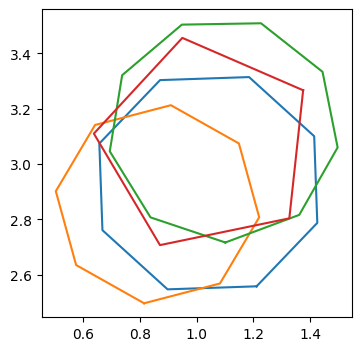

In [3]:
polygon_centres = [[1, 3]]

polygons = generate_polygons(polygon_centres, size_of_clusters=4, noise_level=3.0)

fig, ax = plt.subplots(1, figsize=(4, 4))
for polygon in polygons:
    ax.plot(polygon[0], polygon[1])

Above is a group of four polygons with a random number of sides and orientations, all scattered about the centre at (1,3). We defined the centre of the cluster using the list of lists `polygon_centres`, where each of the inner lists is the coordinates centre of a cluster. The number of polygons in each cluster was specified with `size_of_clusters` and how scattered the polygons are is specified with `noise_level`.

We can see that all of the polygons intersect and clearly form a cluster by eye. Later we will discuss how a cluster is defined in practice, but for now we just assume we have a cluster of polygons. The question is, how best to 'average' them?

### Aggregating polygons (`average_type`)

The first keyword argument (kwargs) investigated is `average_type`. The difficulty with polygon data is there is no clear way to define the average of the cluster for aggregating. This is because each polygon can have a different number of sides/vertices. While the distance between polygons can be found using the ['intersection of union' (IoU) metric](https://en.wikipedia.org/wiki/Jaccard_index), this metric cannot be used directly to find the aggregation of the cluster.

To illustrate the problem, consider a case where aggregation is straightforward, namely how to aggregate a cluster of data points in 2D. This can be done simply by taking their Euclidean average (see [How Data Clustering Works](https://aggregation-caesar.zooniverse.org/How_Clustering_Works.html)). But as the number of vertices can differ between polygons, this approach cannot be used.

This problem is also related to the idea of the average being an object which minimises the variance to the other objects. For a cluster of scattered data points in 2D again this is straightforward: the Euclidean average minimises the Euclidean variance. While an equivalent to the Euclidean variance can be found with the IoU metric for a cluster of points etc, finding a polygon which minimises this variance is difficult as we don't even know how many sides it should have!

Therefore alternative forms of aggregation need to be considered. Below various forms for averaging a cluster of polygons, and hence aggregation, are introduced. We will start with the two simplest forms of averaging the polygons.

To use the `panoptes_aggregation` averages, we need to convert our list of polygons into a data format used internally by `panoptes_aggregation`. We also need a way to convert back to a list of `x` and `y` coordinates. These are done below, along with some helper functions.

In [4]:
data = []

for polygon in polygons:
    dictionary = {}
    xy = np.array([polygon[0], polygon[1]]).T
    dictionary['polygon'] = shapely.Polygon(xy)
    data.append(dictionary)

In [5]:
def shapely_to_x_ylist(polygon):
    return np.array(list(polygon.boundary.coords))

def data_to_x_y_list(data):
    polygons = []

    for i in range(len(data)):
        polygon = data[i]['polygon'] 
        xy = shapely_to_x_ylist(polygon)
        polygons.append([xy[:, 0], xy[:, 1]])
    return polygons

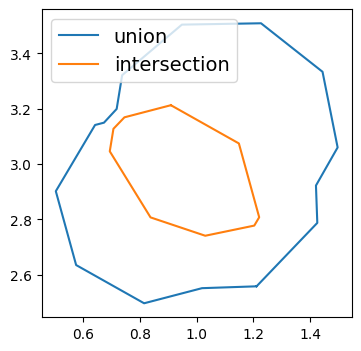

In [6]:
fig, ax = plt.subplots(1, figsize=(4, 4))

union = utils.cluster_average_union(data)
union = shapely_to_x_ylist(union)
ax.plot(union[:, 0], union[:, 1], label='union')

intersection = utils.cluster_average_intersection(data)
intersection = shapely_to_x_ylist(intersection)
ax.plot(intersection[:, 0], intersection[:, 1], label='intersection')

ax.legend(fontsize=14);

The `union` average is simply the union of all of the polygons of the cluster into one large simply-connected polygon. It will always give the largest result and is useful when one is interested in *all* possible regions of interest, without discriminating. However, if a single volunteer misidentifies the region of interest, but has drawn a polygon close enough to be a part of the cluster (a 'cluster outlier'), the results can be skewed by this single volunteer. In summary:

`union` pros:
- Is most likely to identify all of the regions of interest.

`union` cons:
- Can be greatly affected by a single volunteer.


This is to be compared with the `intersection` average, which is the overlap of *all* of the polygons of the cluster. Hence it is always the smallest, but most conservative choice, with the smallest possible uncertainty. In summary:

`intersection` pros:
- Identifies the region of interest with the highest certainty.

`intersection` cons:
- Will most likely miss some of the regions of interest.
- Can return a null result if there is no region where all the polygons intersect.

But what if one is interested in an average which is not either the most generous or the most conservative? This is where either the `last` or `median` averages can be used. To use these two additional information is required. Let's add the information for the `last` average and compute it first, before doing the same for `median`.

In [7]:
# When the polygons were drawn by our four fictitious volunteers
created_at_list = [
    '2025-01-21 10:46:23 UTC',
    '2025-01-25 10:46:21 UTC',
    '2025-02-21 10:46:22 UTC',
    '2025-01-12 17:46:22 UTC'
]
kwargs = {'created_at': created_at_list}

last = utils.cluster_average_last(data, **kwargs)
last = shapely_to_x_ylist(last)

In [8]:
# An array of of the indices of the polygons and the user indices, used to prevent 'self clustering'
X = np.array([[0, 0], [1, 1], [2, 2], [3, 3]])
# Used to determine the members of a cluster for a large data set, is superfluous when all the data is in the same cluster
cdx = np.array([True, True, True, True])

# The matrix of mutual IoU distances between the polygons
distance_matrix = utils.IoU_distance_matrix_of_cluster(cdx, X, data)
kwargs['distance_matrix'] = distance_matrix

median = utils.cluster_average_median(data, **kwargs)
median = shapely_to_x_ylist(median)

Now let's look at both `median` and `last` by themselves, and together with the previous `union` and `intersection`. As the polygons overlap, dashed lines are used in the plot of all the averages.

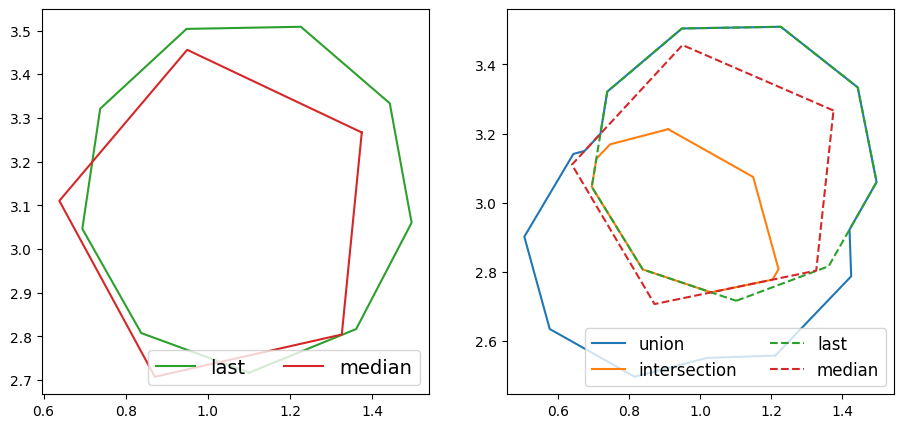

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

ax[0].plot(last[:, 0], last[:, 1], label='last', color=f'C{2}')
ax[0].plot(median[:, 0], median[:, 1], label='median', color=f'C{3}')
ax[0].legend(fontsize=14, ncol=2, loc='lower right')

# For the second plot

ax[1].plot(union[:, 0], union[:, 1], label='union')
ax[1].plot(intersection[:, 0], intersection[:, 1], label='intersection')
ax[1].plot(last[:, 0], last[:, 1], label='last', linestyle='dashed')
ax[1].plot(median[:, 0], median[:, 1], label='median', linestyle='dashed')

ax[1].legend(fontsize=12, ncol=2, loc='lower right');

By comparing with the original cluster from earlier, it is clear that both the `last` and `median` averages are polygons from the original cluster, rather than new polygons, as was the case with `union` and `intersection`.

The `last` average is the last polygon to be created, as defined by the times given in `created_at_list`. This is useful for collaborative workflows, where each volunteer can see the output of previous volunteers. It is then hoped that each volunteer can correct the previous classification and improve, and therefore the most recent polygon should be the most accurate.

`last` pros:
- Is useful for a collaborative workflow, where each classification is improved upon by each volunteer.

`last` cons:
- Assumes the last volunteer *actually did* improve upon the previous classification.

The `median` average is the polygon of the original cluster with the minimum total IoU distance to the other polygons of the cluster. It is named as such as it is defined in a similar way to the [geometric median](https://en.wikipedia.org/wiki/Geometric_median), but as it is difficult to find a polygon of arbitrary sides which minimises the total distance, one of the existing polygons is chosen. One can think of it as choosing the polygon of the cluster which best represents the cluster as a whole. This average is still sensitive to 'outliers' in the cluster, but much less so than the `union` average.

`median` pros:
- It finds the polygon that best represents the cluster as a whole.

`median` cons:
- May miss areas of interest.
- Can still be affected by a single volunteer, although less so than `union`.

The above options for calculating the average are provided to the reducer `panoptes_aggregation.reducers.polygon_reducer` as:

**kwargs**
`average_type`: `union`, `intersection`, `median`, or `last`

An example doing this will be done later.

#### Cluster consensus

The `consensus` of the cluster is found from the mean of the mutual IoU distances. This is a measure of how much agreement there is in the cluster. It is on a scale of 0 to 1. A value of 0 is perfect disagreement (no intersections), while a value of 1 is perfect agreement of the cluster.

In [10]:
consensus = 1 - utils.IoU_cluster_mean_distance(distance_matrix)

print(f'Consensus is {consensus}')

Consensus is 0.48126596282921186


Here we can see that this cluster has middle value, which seems appropriate based on visual inspection. The `consensus` is not a precise value but can be an useful approximation of the overall agreement of the cluster. A particularly low value (whose precise definition will depend on the project in question) might require further investigation by subject experts.

### Contours

Rather than the averages defined above, what if we are interested in the region where at least two volunteer's classifications agree? As this region would easily remove any cluster outliers and hopefully be a good guess of the area of interest. Or equally where three volunteers agree? This is where the contours of the overlap/intersections of polygons can be useful. Here a list of polygons is returned, where the first polygon is the union of all polygons in the cluster, the second is the region where at least two volunteers agree, the third is the region where at least three volunteers agree, and so on. This approach naturally combines the results of both the `union` and `intersection` averages into one output.

As this operation is quite different to taking the average, a different reducer is used, namely `panoptes_aggregation.reducers.polygon_reducer_contours`.

Let's find it and plot the results as a heat map.

In [11]:
def plot_polygon_on_ax(ax, polygon, **kwargs):
    path = Path.make_compound_path(
        Path(np.asarray(polygon.exterior.coords)[:, :2]),
        *[Path(np.asarray(ring.coords)[:, :2]) for ring in polygon.interiors]
    )

    patch = PathPatch(path, **kwargs)
    collection = PatchCollection([patch], **kwargs)
    
    ax.add_collection(collection, autolim=True)
    ax.autoscale_view()
    return collection

def plot_contours(contours, data):
    alpha_scaling = 0.6

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3.5))
    for i in range(len(data)):
        polygon = data[i]['polygon']
        xy = shapely_to_x_ylist(polygon)
        ax1.plot(xy[:, 0], xy[:, 1])
    cmap = colormaps.get_cmap('plasma')
    norm = colors.Normalize(vmin=1, vmax=len(contours))
    for i, contour in enumerate(contours):
        num_agreement = i + 1
        color = cmap(norm(num_agreement))
        alpha = alpha_scaling + (1 - alpha_scaling) * norm(num_agreement)
        plot_polygon_on_ax(ax2, contour, facecolor=color, alpha=alpha)

    cax = ax2.inset_axes([1.04, 0.0, 0.05, 1], transform=ax2.transAxes)
    cb = colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical')
    cb.set_label('# agreement')

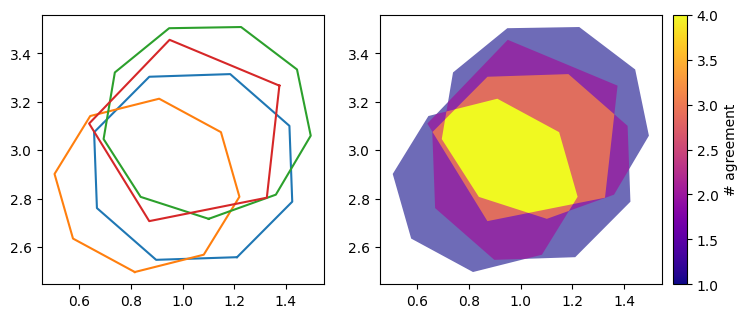

In [12]:
contours = utils.cluster_average_intersection_contours(data, **kwargs)

plot_contours(contours, data)

On the left is the original cluster, while on the right is the contour heat map. Here the colour bar '# agreement' refers to the number of polygons which overlap/intersect in that coloured region. It is clear that the outline of the entire contour map is the `union` average from earlier, while the yellow centre is the `intersection` average. Therefore the contours contain both of these averages, and in some sense superseeds them.

This plot can also be used to estimate the uncertainty of the identification of the region of interest. The largest region is where minimal volunteers agree, and is the most uncertain. While as the contours go inwards, more and more volunteers agree, and the uncertainty reduces.

However, this approach is computationally very expensive. This is because many operations using the [shapely package](https://shapely.readthedocs.io/en/stable/) are required, with the number of operations increasing greatly as the number of polygons in the cluster increases. We can see how much more computationally expensive this approach is using the code below.

In [13]:
# Start the timers
start = time.time()

# Need many of the same computations t get an accurate estimate of the computational time
for i in range(500):
    median = utils.cluster_average_median(data, **kwargs)
# End the imer one
end = time.time()
# Find the time elapsed to run this function 500 times. Do same again for the contours
last_time = start-end

start = time.time()

for i in range(500):
    median = utils.cluster_average_intersection_contours(data, **kwargs)
end = time.time()
# Find the time elapsed to run this function 500 times
contour_time = start-end

print(f'The contours took approximately {contour_time / last_time} times longer to compute than the `last` average')

The contours took approximately 105.7486967003164 times longer to compute than the `last` average


which is a lot longer! So while the reduction contains more information, this comes at the expense of computational efficiency.

### Clustering (`eps`)

Now let us investigate the second main keyword argument (kwargs) for the `panoptes_aggregation.reducers.polygon_reducer`, the parameter `eps`. Remember we have already imported this reducer as `polygon_reducer`. This parameter controls how close together the polygons need to be for a cluster to be found. It has the range 0<`eps`<1. A small value of `eps` (<0.5) will mean that only tightly grouped polygons will be considered a cluster, while a large value of `eps` (>0.5) will mean loosely grouped polygons will be considered a cluster. This will be illustrated below with examples. In practice it has been found that a value of `eps` of 0.5 is adequate for most uses and is the default value. The value of `eps` is used for [DBSCAN algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html), which is used to find the clusters.

Let's create some artificial data, plot it and also transform it into a format that can be reduced by `panoptes_aggregation.reducers.polygon_reducers`. The data will be for four clusters and the identifications done by four fictional volunteers, three of whom understood the task correctly, while the other misunderstood and accidentally created an outlier. Each of the groups of polygons will have a different 'spread', i.e. how much they are dispersed in the group.

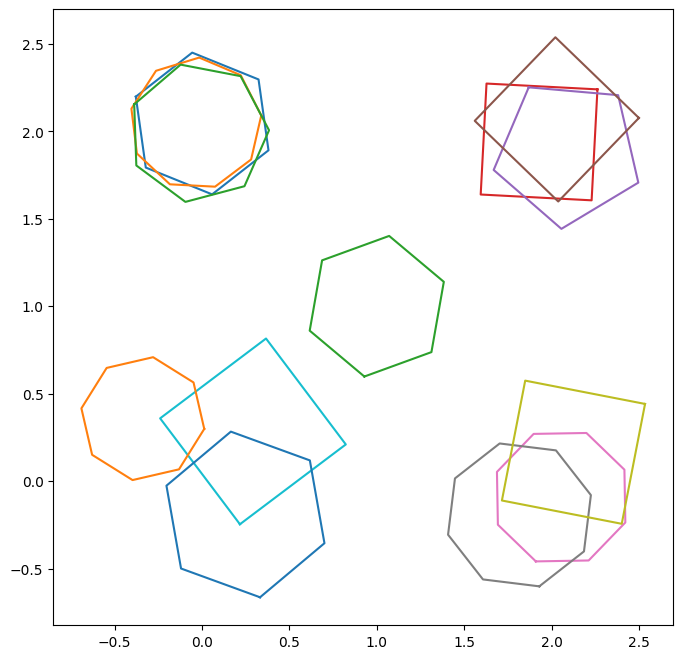

In [14]:
polygons_different_spreads = []

# The paramerer `seed` is used to set the random distribution of the polygons.
# The value of the seed here is chosen to give a representative group
polygons_different_spreads += generate_polygons([[0, 2]], size_of_clusters=3, noise_level=1, seed=1)
polygons_different_spreads += generate_polygons([[2, 2]], size_of_clusters=3, noise_level=3, seed=2)
polygons_different_spreads += generate_polygons([[2, 0]], size_of_clusters=3, noise_level=4, seed=0)
polygons_different_spreads += generate_polygons([[0, 0]], size_of_clusters=3, noise_level=8, seed=13)

# Add the outlier in
polygons_different_spreads += [polygon_generator(6, 1, centre=[1, 1], rotation=20, same_area=True)]

fig, ax = plt.subplots(1, figsize=(8, 8))

for polygon in polygons_different_spreads:
    ax.plot(polygon[0], polygon[1])

X_different_spreads = [
    [0, 0],
    [1, 1],
    [2, 2],
    [3, 0],
    [4, 1],
    [5, 2],
    [6, 0],
    [7, 1],
    [8, 2],
    [9, 0],
    [10, 1],
    [11, 2],
    [12, 3]
]

created_at_different_spreads = [
    '2025-01-21 10:46:20 UTC',
    '2025-01-25 11:46:20 UTC',
    '2025-01-26 16:46:20 UTC',
    '2025-01-28 17:46:20 UTC'
]

data_different_spreads = []

for polygon in polygons_different_spreads:
    data_entry = {}
    # See https://shapely.readthedocs.io/en/2.0.6/reference/shapely.Polygon.html
    data_entry['polygon'] = shapely.Polygon(np.array(polygon).T)
    data_different_spreads.append(data_entry)

processed_data_different_spreads = {'frame0': {'T0_tool0': {'X': X_different_spreads, 'data': data_different_spreads}}}

Above we can see four groups of connected polygons with one outlier. In each group are three polygons, corresponding to our three fictional volunteers. Starting with the top left, we have the most tightly bound group of polygons. As we go around in a clockwise manner, the groups become less and less tightly bound. Whether or not they each can be classified as a 'cluster' depends on the value of `eps` used.

Let's define a function to plot the reduction. On the left will be the original data, coloured by the clusters. Outliers will be identified by a black-dashed line. On the right will be the aggregated clusters, along with the outliers. We will start with the `union` for the `average_type`.

In [15]:
def plot_reduction_and_data(reduction, processed_data, tool='T0_tool0', title=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    cluster_labels = np.array(reduction["frame0"][f'{tool}_cluster_labels'])
    data = processed_data['frame0'][f'{tool}']['data']
    
    outliers = np.array(data)[cluster_labels == -1]

    # Plot the original polygons, with the colours given by their clustering
    for i, label in enumerate(cluster_labels):
        if label == -1:
            color = "k"
            ls = '--'
        else:
            color = f'C{label}'
            ls = '-'
        polygon = data[i]['polygon']
        xy = shapely_to_x_ylist(polygon)
        ax1.plot(xy[:, 0], xy[:, 1], color=color, linestyle=ls)

    # Plot the outliers on the right as well
    for outlier in outliers:
        polygon = outlier['polygon']
        xy = shapely_to_x_ylist(polygon)
        ax2.plot(xy[:, 0], xy[:, 1], color="k", linestyle="dashed")

    # Now let's plot the reduction on the right
    for xs, ys in zip(reduction["frame0"][f'{tool}_clusters_x'], reduction["frame0"][f'{tool}_clusters_y']):
        ax2.plot(xs, ys)
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_ylim(ax1.get_ylim())

    if isinstance(title, str):
        fig.suptitle(title, fontsize=14)

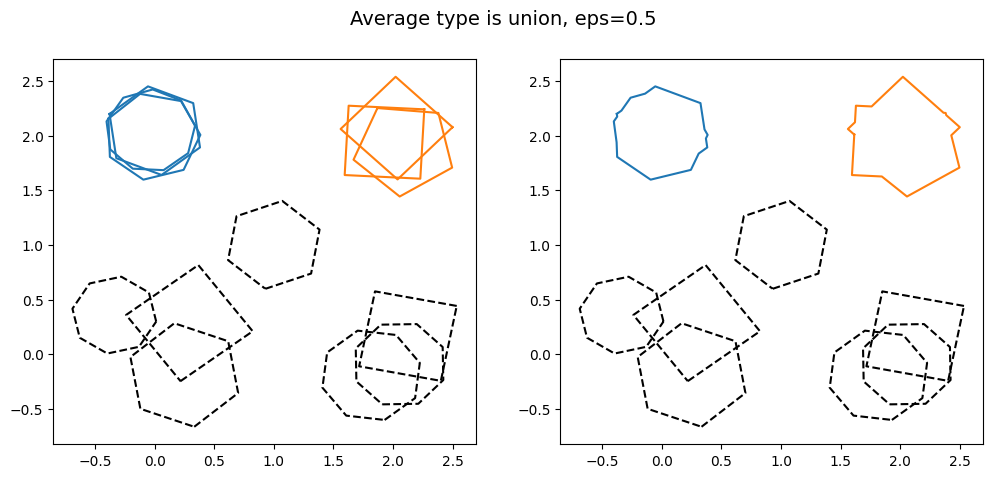

In [16]:
kwargs = {'average_type': 'union', 'eps': 0.5, 'created_at': created_at_different_spreads}
# The _original is to allow us to access the unwrapped reduction function
reduction_different_spreads = polygon_reducer._original(processed_data_different_spreads, **kwargs)
plot_reduction_and_data(
    reduction_different_spreads,
    processed_data_different_spreads,
    title=f'Average type is {kwargs["average_type"]}, eps={kwargs["eps"]}'
)

The two most tightly bound groups of polygons were grouped into a cluster, while the rest are considered outliers with this value of `eps`, as they are shown with a black-dashed line. Note that the union average was used.

Now let's look at the effect of changing the value of `eps` used. For additional illustration, the `average_type` will also be cycled through.

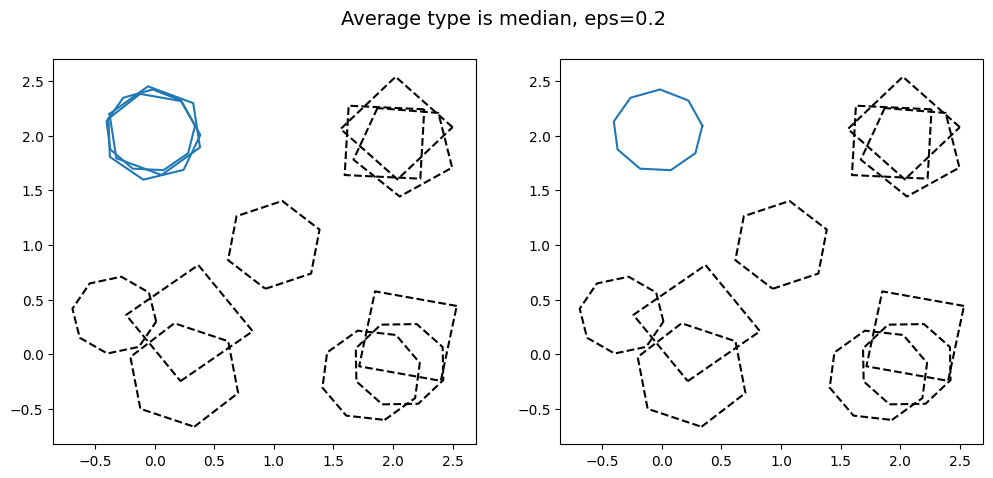

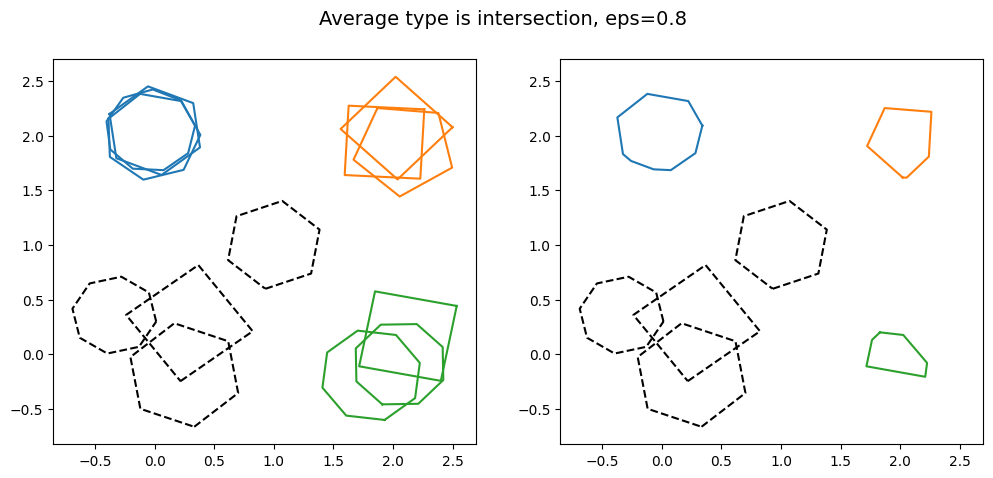

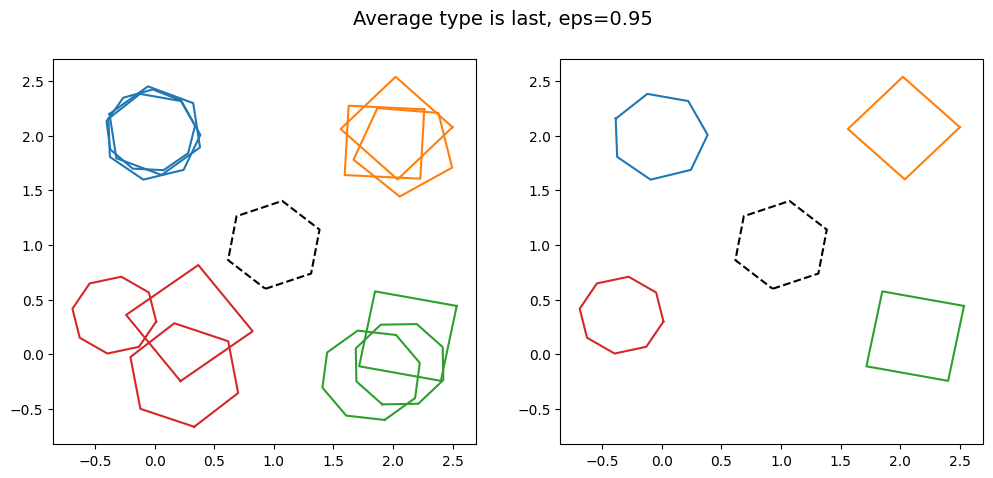

In [17]:
kwargs = {'average_type': 'median', 'eps': 0.2, 'created_at': created_at_different_spreads}
reduction_different_spreads = polygon_reducer._original(processed_data_different_spreads, **kwargs)
plot_reduction_and_data(
    reduction_different_spreads,
    processed_data_different_spreads,
    title=f'Average type is {kwargs["average_type"]}, eps={kwargs["eps"]}'
)

kwargs = {'average_type': 'intersection', 'eps': 0.8, 'created_at': created_at_different_spreads}
reduction_different_spreads = polygon_reducer._original(processed_data_different_spreads, **kwargs)
plot_reduction_and_data(
    reduction_different_spreads,
    processed_data_different_spreads,
    title=f'Average type is {kwargs["average_type"]}, eps={kwargs["eps"]}'
)

kwargs = {'average_type': 'last', 'eps': 0.95, 'created_at': created_at_different_spreads}
reduction_different_spreads = polygon_reducer._original(processed_data_different_spreads, **kwargs)
plot_reduction_and_data(
    reduction_different_spreads,
    processed_data_different_spreads,
    title=f'Average type is {kwargs["average_type"]}, eps={kwargs["eps"]}'
)

It is clear that as the value of `eps` is increased, more  and more of the groups of polygons are clustered together. This shows the effect changing the value of `eps` has. Note that for large `eps`, the probability of including an outlier in the cluster increases.

Also note how different the aggregated data looks as `average_type` is changed. In particular note how the bottom right cluster, coloured in green, has a very small aggregation when `intersection` is used, as the region where all three polygons intersect is small. This is more extreme for the bottom left cluster in red would. If we had used `intersection` with `eps`=0.95, the bottom left cluster in red would have returned a null output, as there is no region where all of the polygons intersect. The outlier in the centre is always excluded, as it does not intersect any other polygon.

Finally, let's look at the consensus score for the different clusters.

In [18]:
kwargs = {'average_type': 'last', 'eps': 0.95, 'created_at': created_at_different_spreads}
reduction_different_spreads = polygon_reducer._original(processed_data_different_spreads, **kwargs)
reduction_different_spreads['frame0']['T0_tool0_consensus']

[0.832433999646646,
 0.5181782002556223,
 0.32898807343701864,
 0.08172908729406758]

This is in clockwise order starting with the top left cluster. The first cluster has a consensus of above >0.8, and as a value of 1 corresponds to perfect agreement, this consensus score seems reasonable by visual inspection. The consensus then reduces as the clusters become looser and more spread out, with the final cluster having a value of <0.1. This final value also seems about right by inspection, as two of the polygons of this cluster do not even intersect. For real data a subject expert might need to look at the last two clusters due to their low consensus.

#### An aside - overlapping clusters
When a small value of `eps` is used, two separate clusters with some overlap can be clustered together into a single cluster. To illustrate, let's look at the case below.

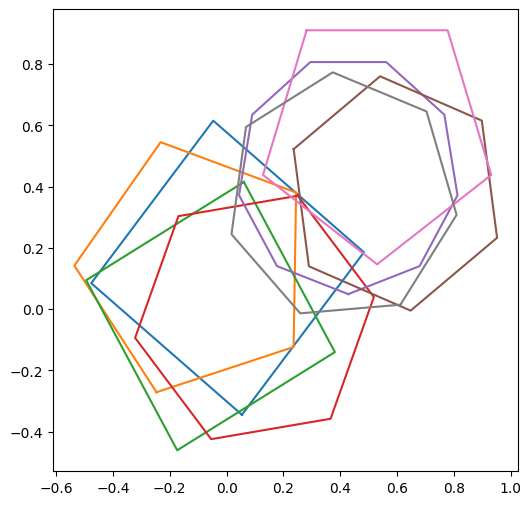

In [19]:
polygons_two_clusters = []

# The paramerer `seed` is used to set the random distribution of the polygons.
# The value of the seed here is chosen to give a representative group
polygons_two_clusters += generate_polygons([[0, 0]], size_of_clusters=4, noise_level=3, seed=1)
polygons_two_clusters += generate_polygons([[0.5, 0.5]], size_of_clusters=4, noise_level=3, seed=2)

fig, ax = plt.subplots(1, figsize=(6,6))

for polygon in polygons_two_clusters:
    ax.plot(polygon[0], polygon[1])

X_two_clusters = [[0, 0], [1, 1], [2, 2], [3, 3], [4, 0], [5, 1], [6, 2], [7, 3]]

created_at_two_clusters = [
    '2025-01-21 10:46:20 UTC',
    '2025-01-25 11:46:20 UTC',
    '2025-01-26 16:46:20 UTC',
    '2025-01-28 17:46:20 UTC'
]

data_two_clusters = []

for polygon in polygons_two_clusters:
    data_entry = {}
    # See https://shapely.readthedocs.io/en/2.0.6/reference/shapely.Polygon.html
    data_entry['polygon'] = shapely.Polygon(np.array(polygon).T)
    data_two_clusters.append(data_entry)

processed_data_two_clusters = {'frame0': {'T0_tool0': {'X': X_two_clusters, 'data': data_two_clusters}}}

We can see that the two clusters are intersecting. If the default value of `eps` = 0.5 is used, they are found to be separate clusters. But if we use `eps` =0.95, the two clusters are grouped together. Let's show this:

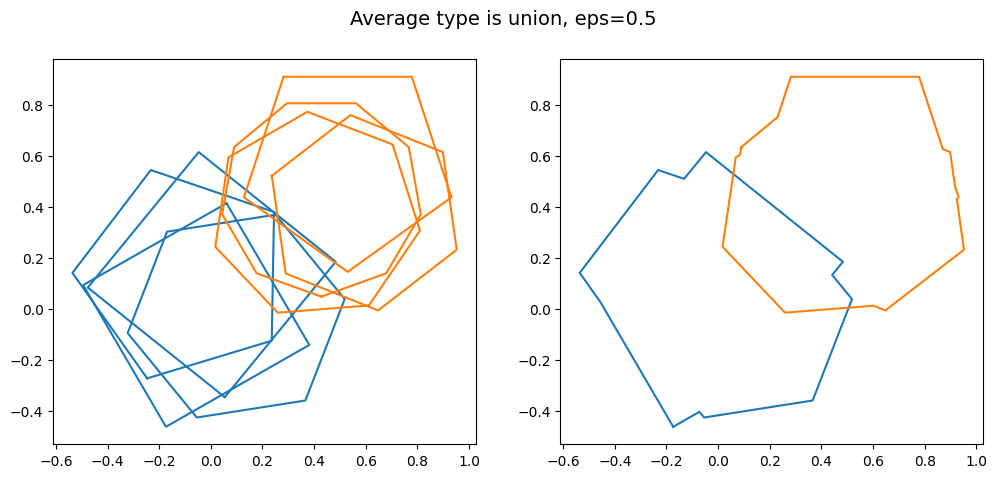

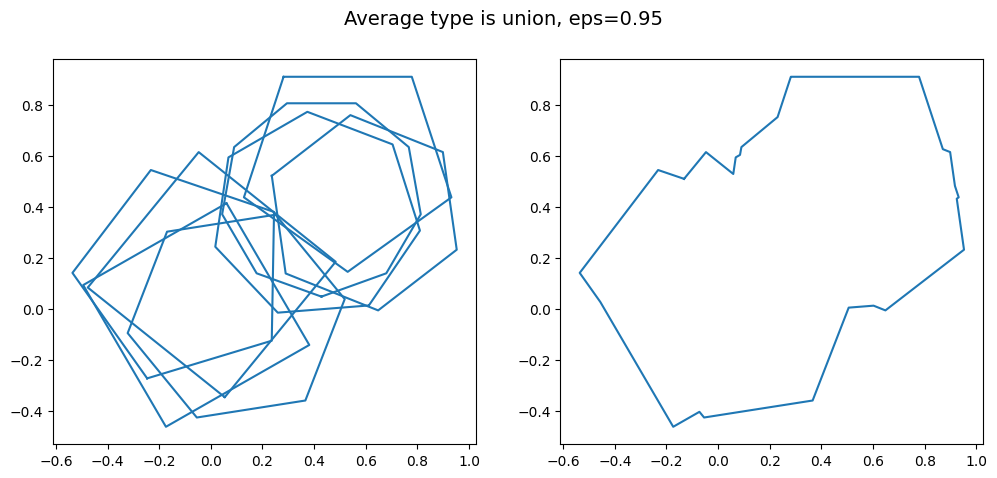

In [20]:
kwargs = {'average_type': 'union', 'eps': 0.5, 'created_at': created_at_two_clusters}
reduction_two_clusters = polygon_reducer._original(processed_data_two_clusters, **kwargs)
plot_reduction_and_data(
    reduction_two_clusters,
    processed_data_two_clusters,
    title=f'Average type is {kwargs["average_type"]}, eps={kwargs["eps"]}'
)

kwargs = {'average_type': 'union', 'eps': 0.95, 'created_at': created_at_two_clusters}
reduction_two_clusters = polygon_reducer._original(processed_data_two_clusters, **kwargs)
plot_reduction_and_data(
    reduction_two_clusters,
    processed_data_two_clusters,
    title=f'Average type is {kwargs["average_type"]}, eps={kwargs["eps"]}'
)

Whether or not merging these two close clusters together into one supercluster is desirable depends on the context of your project.

### Minimum cluster size (`min_samples`)

The final keyword argument (kwargs) to discuss is `min_samples`. This is the minimum number of polygons requred to form a cluster. This is best illustrated with clusters with different numbers of polygons in them. Let's make such a set of data, with the top left cluster having two members, the top right having 3 and the bottom left having 4. We can then see what happens as `min_samples` is varied.

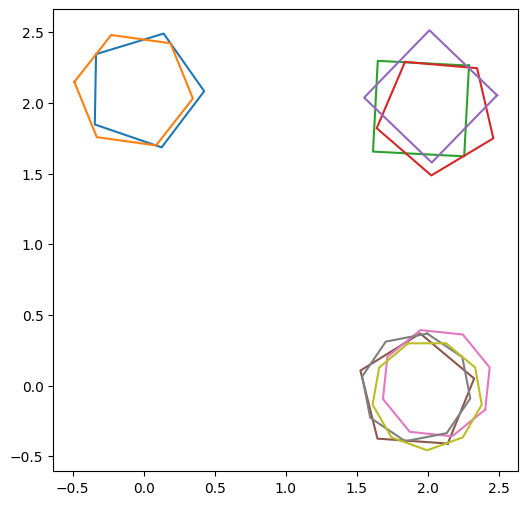

In [21]:
polygons_different_sizes = []

# The paramerer `seed` is used to set the random distribution of the polygons.
# The value of the seed here is chosen to give a representative group
polygons_different_sizes += generate_polygons([[0, 2]], size_of_clusters=2, noise_level=2, seed=1)
polygons_different_sizes += generate_polygons([[2, 2]], size_of_clusters=3, noise_level=2, seed=2)
polygons_different_sizes += generate_polygons([[2, 0]], size_of_clusters=4, noise_level=2, seed=3)

fig, ax = plt.subplots(1, figsize=(6, 6))

for polygon in polygons_different_sizes:
    ax.plot(polygon[0], polygon[1])

X_different_sizes = [[0, 0], [1, 1], [2, 0], [3, 1], [4, 2], [5, 0], [6, 1], [7, 2], [8, 3]]

created_at_different_sizes  = [
    '2025-01-21 10:46:20 UTC',
    '2025-01-25 11:46:20 UTC',
    '2025-01-26 16:46:20 UTC',
    '2025-01-28 17:46:20 UTC'
]

data_different_sizes = []

for polygon in polygons_different_sizes:
    data_entry = {}
    # See https://shapely.readthedocs.io/en/2.0.6/reference/shapely.Polygon.html
    data_entry['polygon'] = shapely.Polygon(np.array(polygon).T)
    data_different_sizes.append(data_entry)

processed_data_different_sizes = {'frame0': {'T0_tool0': {'X': X_different_sizes, 'data': data_different_sizes}}}

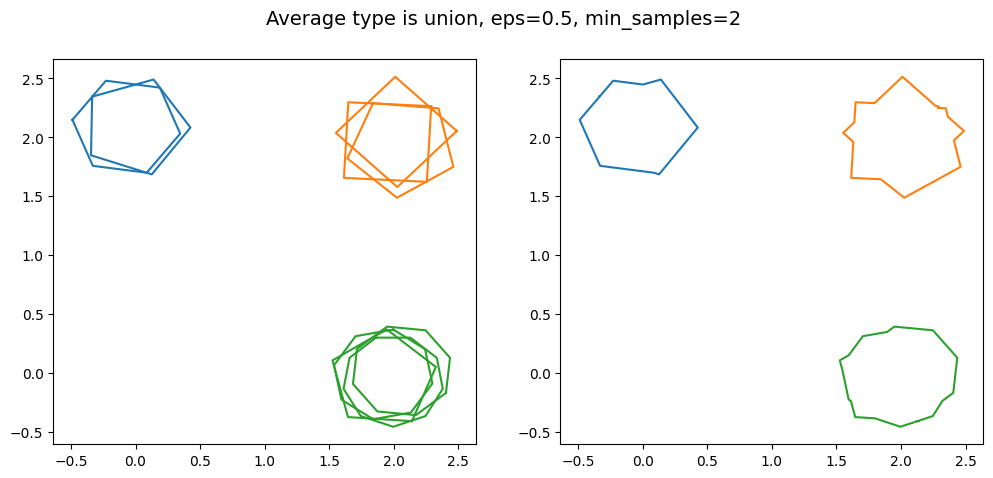

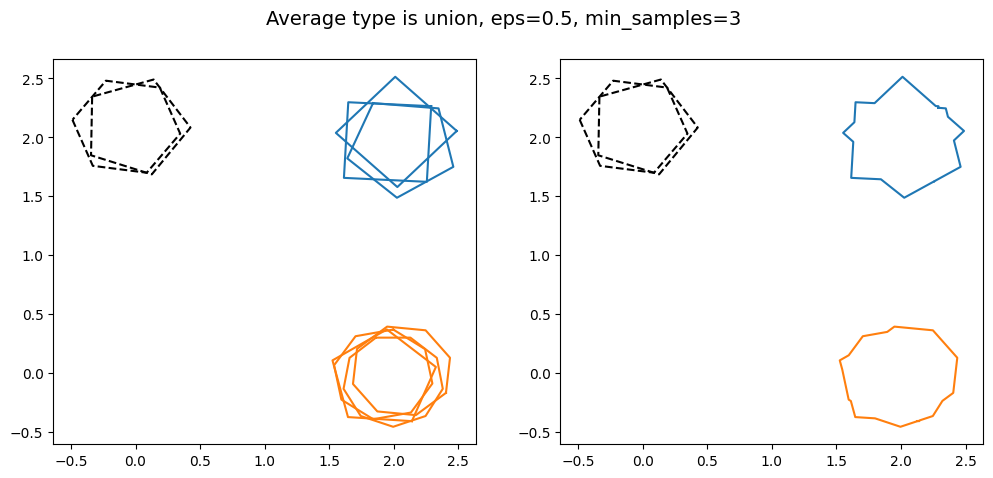

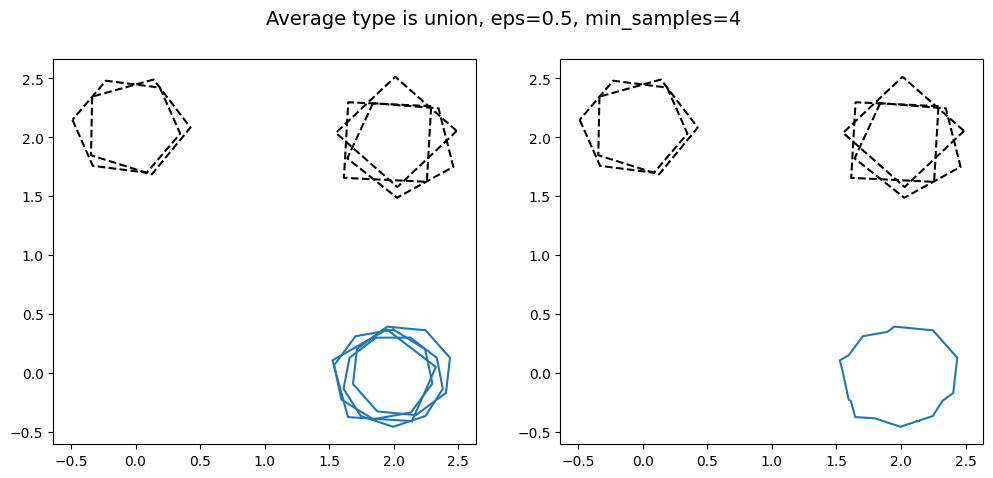

In [22]:
kwargs = {'average_type': 'union', 'eps': 0.5, 'created_at': created_at_different_sizes, 'min_samples': 2}
reduction_different_sizes = polygon_reducer._original(processed_data_different_sizes, **kwargs)
title = f'Average type is {kwargs["average_type"]}, eps={kwargs["eps"]}, min_samples={kwargs["min_samples"]}'
plot_reduction_and_data(reduction_different_sizes, processed_data_different_sizes, title=title)

kwargs['min_samples'] = 3
reduction_different_sizes = polygon_reducer._original(processed_data_different_sizes, **kwargs)
title = f'Average type is {kwargs["average_type"]}, eps={kwargs["eps"]}, min_samples={kwargs["min_samples"]}'
plot_reduction_and_data(reduction_different_sizes, processed_data_different_sizes, title=title)

kwargs['min_samples'] = 4
reduction_different_sizes = polygon_reducer._original(processed_data_different_sizes, **kwargs)
title = f'Average type is {kwargs["average_type"]}, eps={kwargs["eps"]}, min_samples={kwargs["min_samples"]}'
plot_reduction_and_data(reduction_different_sizes, processed_data_different_sizes, title=title)

As `min_samples` increases, the minimum number of polygons that need to intersect each other in order to be classified as a cluster. This can be useful for projects where the reduction needs a high degree of certainty, as this guarantees a minimum number of volunteers agreed for the region of interest to be identified in the final reduction.

### Contours for groups of cluster
The final investigation for this artificial data is to plot the contours. This gives the uncertainty of the cluster in addition to the consensus value.

We will use the group of four clusters, each with a varying spread of polygons, from earlier. To do so we again use `panoptes_aggregation.reducers.polygon_reducer_contours` (which we have already imported).

In [23]:
def plot_reduction_contours_and_data(reductions, processed_data, tool='T0_tool0', title=None):
    alpha_scaling = 0.6
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    cluster_labels = np.array(reductions[0]["frame0"][f'{tool}_cluster_labels'])
    data = processed_data['frame0'][f'{tool}']['data']
    
    outliers = np.array(data)[cluster_labels==-1]

    # Plot the original data, coloured by the clusters
    for i, label in enumerate(cluster_labels):
        if label==-1:
            color = "k"
            ls = '--'
        else:
            color = f'C{label}'
            ls = '-'
        polygon = data[i]['polygon']
        xy = shapely_to_x_ylist(polygon)
        ax1.plot(xy[:, 0], xy[:, 1], color=color, linestyle=ls)

    # Plot the outliers on the reduction plot
    for outlier in outliers:
        polygon = outlier['polygon']
        xy = shapely_to_x_ylist(polygon)
        ax2.plot(xy[:, 0], xy[:, 1], color="k", linestyle="dashed")

    # Now plot the contours
    contour_levels = [reduction['frame0'][f'{tool}_number_of_contours'] for reduction in reductions]
    max_contour = np.max(contour_levels)
    cmap = colormaps.get_cmap('plasma')
    norm = colors.Normalize(vmin=1, vmax=max_contour)
    for reduction in reductions:
        num_agreement = 1
        for xs, ys in zip(reduction["frame0"][f'{tool}_contours_x'], reduction["frame0"][f'{tool}_contours_y']):
            color = cmap(norm(num_agreement))
            polygon = shapely.Polygon(np.array([xs, ys]).T)
            alpha = alpha_scaling + (1 - alpha_scaling) * norm(num_agreement)
            plot_polygon_on_ax(ax2, polygon, facecolor=color, alpha=alpha)
            num_agreement += 1

    cax = ax2.inset_axes([1.04, 0.0, 0.05, 1], transform=ax2.transAxes)
    cb = colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical')
    cb.set_label('# agreement')
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_ylim(ax1.get_ylim())

    if isinstance(title, str):
        fig.suptitle(title, fontsize=14)

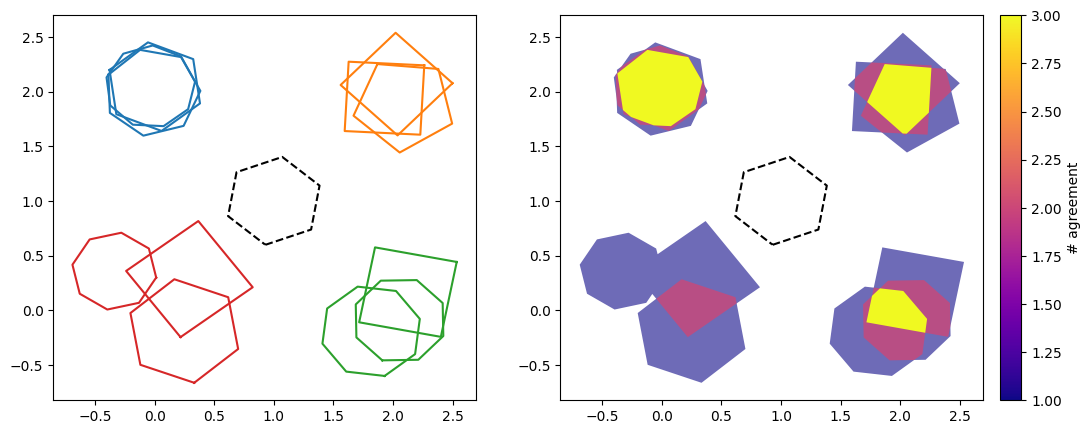

In [24]:
# We still need a value of eps=0.95 to cluster the bottom left group
kwargs = {'eps': 0.95, 'created_at': created_at_different_spreads}
reductions_different_spreads = polygon_reducer_contours._original(processed_data_different_spreads, **kwargs)
plot_reduction_contours_and_data(reductions_different_spreads, processed_data_different_spreads)

For the top cluster with the highest consensus score, unsurprisingly we see that the cluster is dominated by the area of agreement between the three 'volunteers'. But as we go around clockwise, and each of the clusters becomes more spread out with less intersections/overlap, the heat map clearly shows this effect. Again, it not only gives us the same information as the `union` and `intersection` choices for `average_type`, but additionally this tells us about the levels of certainty in the classification of the regions of interest.

For the cluster with the lowest consensus score of 0.078 (the bottom left cluster), there is no region of agreement of all three volunteers (no region of intersection/overlap level 3). The two regions where two volunteers agreed are also disconnected. Therefore only the largest region is returned as the contour.

## 'Realistic' project - extraction and reduction
Now we understand what effect the kwargs `average_type`, `eps` and `min_samples` have on the reduction, and what the contours are, let's investigate a 'realistic' project. This 'realistic' project is about cute cat photos! This is the standard Zooniverse test project, as it contains a good range of examples and edge cases. A group of volunteers were asked to draw around the head and ears on photos of cats. They could choose either the freehand or polygon tools (the data processing will be the same for both). The freehand tool is labelled as `T0_toolIndex0` and the polygon tool as `T0_toolIndex1`. Almost all volunteers choose to use the freehand tool, which is what we will focus on here (the process is the same for the polygon tool but `T0_toolIndex1` is used instead of `T0_toolIndex0`). A few volunteers were also asked to be tricksters and purposefully disruptive. Can we successfully aggregate the data, and remove the tricksters?

To run this code on your machine, make sure you have the downloaded files [cat-subjects.csv](_static/cat-project-subjects.csv) and [cat-project-classifications.csv](_static/cat-project-classifications.csv). Use `subjects_file_location` and `classifications_file_location` to define where these files are located on your machine. For this notebook we have these files stored in a folder called `_static`.  The directory where the extractions and reductions are saved to is also defined.

To start, let's load in the subject and classification files using [`pandas`](https://pandas.pydata.org/). We will also plot some of the cute photos!

In [25]:
# The locations of the subject and classification files needed to run the code below
# If running on your own machine, simply put the location of where you downloaded these
# files to. E.g. if in the same folder as this notebook, just used
# 'cat-project-subjects.csv' and 'cat-project-classifications.csv'
subjects_file_location = '_static/cat-project-subjects.csv'
classifications_file_location = '_static/cat-project-classifications.csv'

# The directory where you want the extractions and reductions to live. Here we use _static/
output_folder = '_static/'

subjects = pandas.read_csv(subjects_file_location)
classifications = pandas.read_csv(classifications_file_location)

# List of the subject IDs, in order
subject_ids_list = list(subjects['subject_id'])
unique_subject_ids = list(set(subject_ids_list))
unique_subject_ids.sort()

# Useful to a have a list of the urls for the images
locations_list = []

# Make list of strings from strings, by converting the strings to dictioanries then to strings again
for subject_id in unique_subject_ids:
    i = subject_ids_list.index(subject_id)
    loc = eval(subjects["locations"][i])
    loc = loc["0"]
    locations_list.append(loc)

We can retrieve the images from their URLs using Python's `request` package.

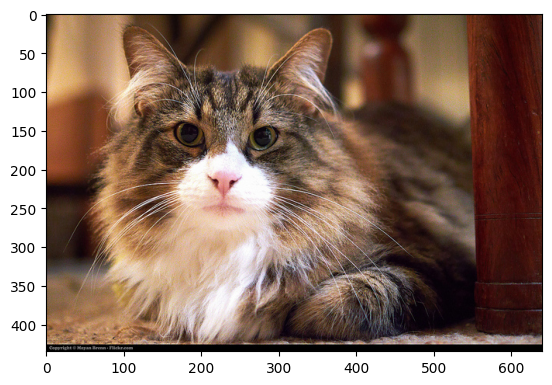

In [26]:
response = requests.get(locations_list[1])
img = Image.open(BytesIO(response.content))
plt.imshow(img);

### Extraction

The data from the volunteers is provided in the classification file above. This file is not in the most useful format and also contains a lot of data we don't need. That is where [extractors](https://aggregation-caesar.zooniverse.org/extractors.html) come in. They process the classification file into a more useful format.

Normally the extractions are done via [the command line](https://aggregation-caesar.zooniverse.org/Scripts.html) using `.yaml` files to define the configuration, or with [the GUI](https://aggregation-caesar.zooniverse.org/GUI.html). But as this guide is based on a notebook, here we need to specify the configuration of the extraction explicitly in a cell, effectively using a string with the same information as a `.yaml` file. It will be the same for the reductions. Examples of how to use the command line will also be given for completeness. To define the configuration we need to know some information about the classifications: the workflow ID and the workflow version. This is contained in the classification file, and can be found below.

In [27]:
print('workflow_id is '+str(set(classifications['workflow_id'])))
print('workflow_version is '+str(set(classifications['workflow_version'])))

workflow_id is {28090}
workflow_version is {4.4, 8.7, 13.16, 13.14, 13.19}


We should use the most recent workflow version. See the page on [configuration](https://aggregation-caesar.zooniverse.org/Scripts.html#configure-the-extractors-and-reducers) for more details for what these are. For our purposes these are just parameters to be specified for the `config` file. The `workflow_id`, `workflow_version` are both defined in the `config`, while `'extractor_config'` specifies the extractor used and the task.

The extraction is done using `extract_csv`, which will run all of the data processing required and output the extractions into a .csv file. We need to tell the extractor what file contains the classifications, which is the first argument of `extract_csv`. the second argument is our `config`. The third is the directory we want to save the extraction and the fourth gives the name of the file, which we prefaced by the extractor used (here `polygon_extractor`). The fifth hides the display of the progress bar, which is not needed here as the extraction is done in seconds for a project this small.

In [50]:
extractor_config = StringIO('''{
    'workflow_id': 28090,
    'workflow_version': '13.19',
    'extractor_config': {'polygon_extractor': [{'task': 'T0'}]}
}''')

extraction_filename = extract_csv(
    classifications_file_location,
    extractor_config,
    output_dir=output_folder,
    output_name='extractions',
    hide_progressbar=True
);

extraction_file_location = extraction_filename[0]
extractions = pandas.read_csv(extraction_file_location)

The above reduction should run in a few seconds. This file can be found [here](_static/polygon_extractor_extractions.csv).

If you would like to run the extractor using the command line scripts, there is example [config file](_static/cat_project_extractor_config.yaml). This is the same information as our above `config` as an explicit `.yaml` file. To then run the extraction, assuming you have the command line open in the same directory as the `_static` folder exists, would be the following command

`panoptes_aggregation extract _static/cat-project-classifications.csv _static/cat_project_extractor_config.yaml -d _static/ -o extractions`

This will save the reduction in the `_static` folder. It is perfectly equivalent to the notebook approach in the cell above.

Let's have a look at the first few lines of this file.

In [69]:
extractions.iloc[:4]

classification_id    user_name    user_id  workflow_id task  \
0          613379977  joe_jackson  2820500.0        28090   T0   
1          613379992  joe_jackson  2820500.0        28090   T0   
2          613380007  joe_jackson  2820500.0        28090   T0   
3          613380046  joe_jackson  2820500.0        28090   T0   

                created_at  subject_id          extractor  \
0  2025-01-30 09:48:51 UTC      458026  polygon_extractor   
1  2025-01-30 09:49:07 UTC      458046  polygon_extractor   
2  2025-01-30 09:49:24 UTC      458050  polygon_extractor   
3  2025-01-30 09:49:43 UTC      458027  polygon_extractor   

   data.classifier_version data.aggregation_version  \
0                      2.0                    5.0.0   
1                      2.0                    5.0.0   
2                      2.0                    5.0.0   
3                      2.0                    5.0.0   

                     data.frame0.T0_toolIndex0_pathX  \
0  [[155.11, 155.11, 154.58, 154.05, 153.51, 152....   
1  [[354.89, 354.39, 352.9, 351.9, 350.9, 349.91,...   
2  [[235.76, 237.26, 238.26, 239.25, 240.25, 241....   
3  [[284.11, 285.11, 285.61, 286.6, 288.6, 290.59...   

                     data.frame0.T0_toolIndex0_pathY  \
0  [[431.85, 431.31, 430.78, 429.71, 428.64, 427....   
1  [[256.45, 255.45, 254.95, 254.46, 253.96, 253....   
2  [[276.88, 276.88, 276.88, 277.38, 277.38, 277....   
3  [[322.74, 322.74, 323.24, 323.24, 323.74, 324....   

  data.frame0.gold_standard data.frame0.T0_toolIndex1_pathX  \
0                     False                             NaN   
1                     False                             NaN   
2                     False                             NaN   
3                     False                             NaN   

  data.frame0.T0_toolIndex1_pathY  
0                             NaN  
1                             NaN  
2                             NaN  
3                             NaN

We can see four rows of data with various columns. The rows are the individual extractions done by a volunteer for a particular subject (this case an image), and the columns contain the data of this extraction. The extraction is all of the classifications done by that volunteer for a certain subject, along with other useful information, stored as a dictionary. For example, all of the freehand drawing information is stored in the 'data.frame0.T0_toolIndex0_pathX' and 'data.frame0.T0_toolIndex0_pathY' columns. Other data is also included, such as the user of the volunteer, when the extraction was created etc. We can use the 'subject_id' column to match the extraction to the images from earlier, whose urls are stored in `locations_list`.

For a larger project, the `extractions` file can contain tens of thousands (or even more) extractions of a similar overall format to above. There can be multiple extractions per subject, corresponding to the response of multiple volunteers. Let's start with plotting one of these using the data in 'data.frame0.T0_toolIndex0_pathX' and 'data.frame0.T0_toolIndex0_pathY' columns for the subject we looked at previously.

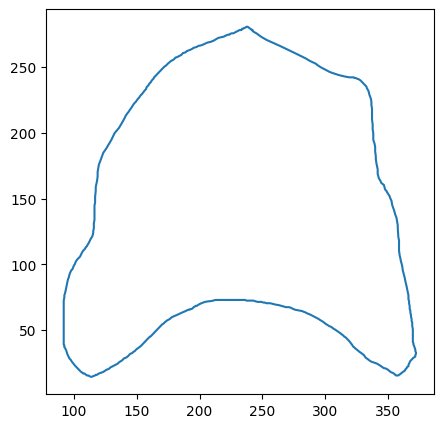

In [61]:
extraction = extractions.iloc[13]
# The data is stored as a string, so we need to use eval(to make it into a list)
x = eval(extraction['data.frame0.T0_toolIndex0_pathX'])
y = eval(extraction['data.frame0.T0_toolIndex0_pathY'])
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(x[0], y[0])

Without the original image, this is not very helpful! Also there maybe other extractions for this same image in the `extractions` file. So let's create a function which plots the image and all of the extractions for a particular subject ID. This is done below, where we also plot the same subject as before.

In [62]:
def plot_img_and_drawing_extraction(subject_id, extractions, locations_list, tool='T0_toolIndex0'):
    # First plot the image
    subject_id_list = list(set(extractions["subject_id"]))
    subject_id_list.sort()
    location = locations_list[subject_id_list.index(subject_id)]
    response = requests.get(location)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)

    # Find the total responses to this subject id
    extractions_subject_id_list = list(extractions["subject_id"])
    indices_extraction_file = []

    # Find the extractions with this subject ID
    for i, value in enumerate(extractions_subject_id_list):
        if value == subject_id:
            indices_extraction_file.append(i)

    # Plot the classifications on top of the subject image
    for i, index in enumerate(indices_extraction_file):
        if isinstance(extractions[f'data.frame0.{tool}_pathY'][index], str):
            x = eval(extractions[f'data.frame0.{tool}_pathX'][index])
            y = eval(extractions[f'data.frame0.{tool}_pathY'][index])
            # For each line in this extraction, need to plot the line separately
            for j in range(len(x)):
                plt.plot(x[j], y[j], ms=2, alpha=1.)

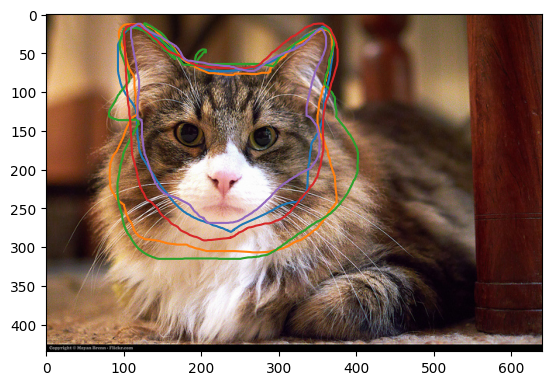

In [63]:
plot_img_and_drawing_extraction(unique_subject_ids[1], extractions, locations_list, tool='T0_toolIndex0')

Much clearer! On this project volunteers were asked to use the freehand line tool to draw around the cat's face. We can see that multiple volunteers have done a good job. They are in broad agreement. Some of the classifications are not closed, but that is ok as the reducer will do this automatically. 

Now let's look at a case with one of our tricksters!

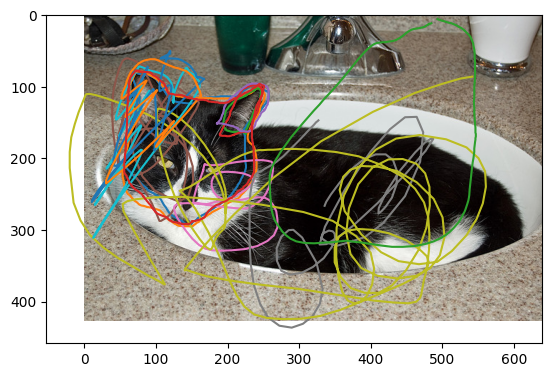

In [32]:
plot_img_and_drawing_extraction(unique_subject_ids[17], extractions, locations_list, tool='T0_toolIndex0')

In this case we can see at least one of our volunteers we deliberately not following the given instructions.

### Reduction

The overall process is similar as for doing the extractions. We again need to define the `config` file for the reduction in a cell (usually this would be done via [the command line](https://aggregation-caesar.zooniverse.org/Scripts.html), whose command is also given). The first is to specify what reducer we will use. Then we specify how we want this reducer to process the data, using the keyword arguments from earlier: `average_type`, `eps` and `min_samples`. To start, let's use the default settings, which means we use `median` for `average_type`, 0.5 for `eps` and 2 for `min_samples`.

The reduction file will have one *row per subject*, so each photo will correspond to one row in the file, as we shall see.

The reduction is done using `reduce_csv`, which will run all of the data processing required and output the reductions into a .csv file. We need to tell the reducer what file contains the extractions, which is the first argument given. The second argument is the `config` defining how we want the reduction to be completed. Again, the third and fourth arguments are just the reduction-file directory and name of the file. The fifth just hides the display of the progress bar, which is not needed for this small project.

In [33]:
reducer_config = StringIO('''{
    'reducer_config': {'polygon_reducer': {
            'average_type': 'median',
            'eps': 0.5,
            'min_samples': 2
        }
    }
}''')

reduction_file_location = reduce_csv(
    extraction_file_location,
    reducer_config,
    output_dir=output_folder,
    output_name='reductions_median',
    hide_progressbar=True
);

reductions_median = pandas.read_csv(reduction_file_location)

The above reduction should run in a few seconds. This file can be found [here](_static/polygon_reducer_reductions_median.csv).

Again, If you would like to run the extractor using the command line scripts, there is example [config file](_static/cat_project_reducer_config.yaml). To then run the reduction, assuming you have the command line open in the same directory as the `_static` folder exists, would be the following command

```panoptes_aggregation reduce _static/polygon_extractor_extractions.csv _static/cat_project_reducer_config.yaml -d _static/ -o reductions_median```

This will save the `polygon_reducer_reductions_median.csv` file in the `_static` folder. Here the argument `-d` is the directory for the file, `-o` is the same for the file, the same as in the cell above.

Let's have a look at the first few lines of this file.

In [70]:
reductions_median.iloc[:4]

subject_id  workflow_id task          reducer data.aggregation_version  \
0      458021        28090   T0  polygon_reducer                    5.0.0   
1      458022        28090   T0  polygon_reducer                    5.0.0   
2      458023        28090   T0  polygon_reducer                    5.0.0   
3      458024        28090   T0  polygon_reducer                    5.0.0   

            data.frame0.T0_toolIndex0_cluster_labels  \
0                                             [0, 0]   
1                                    [0, 0, 0, 0, 0]   
2  [0, 1, -1, -1, -1, 1, -1, -1, 0, 1, 0, 0, 1, -...   
3                                               [-1]   

  data.frame0.T0_toolIndex0_clusters_count  \
0                                      [2]   
1                                      [5]   
2                                   [6, 5]   
3                                      NaN   

                data.frame0.T0_toolIndex0_clusters_x  \
0  [[450.57, 449.68, 447.89, 444.31, 443.42, 439....   
1  [[237.02, 235.03, 234.04, 230.56, 229.07, 225....   
2  [[444.61, 445.61, 447.6, 448.6, 452.09, 454.08...   
3                                                NaN   

                data.frame0.T0_toolIndex0_clusters_y  \
0  [[489.22, 485.64, 482.07, 470.45, 468.67, 463....   
1  [[287.95, 288.45, 288.45, 288.95, 288.95, 289....   
2  [[200.62, 201.12, 202.12, 203.12, 204.61, 205....   
3                                                NaN   

      data.frame0.T0_toolIndex0_consensus  data.parameters.min_samples  \
0                     [0.821361511682781]                            2   
1                    [0.7301441252946794]                            2   
2  [0.64681335230365, 0.5914736410023801]                            2   
3                                     NaN                            2   

   data.parameters.eps data.parameters.average_type  \
0                  0.5                       median   
1                  0.5                       median   
2                  0.5                       median   
3                  0.5                       median   

  data.frame0.T0_toolIndex1_cluster_labels  \
0                                      NaN   
1                                      NaN   
2                                     [-1]   
3                                      NaN   

  data.frame0.T0_toolIndex1_clusters_count  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   

  data.frame0.T0_toolIndex1_clusters_x data.frame0.T0_toolIndex1_clusters_y  \
0                                  NaN                                  NaN   
1                                  NaN                                  NaN   
2                                  NaN                                  NaN   
3                                  NaN                                  NaN   

  data.frame0.T0_toolIndex1_consensus  
0                                 NaN  
1                                 NaN  
2                                 NaN  
3                                 NaN

As with the extractions file, we can see three rows of data with various columns. The rows are the individual reductions for a particular subject (this case an image), and the columns contain the data of this reduction. The reduction is the aggregation of multiple volunteers classifications into a single answer using clustering. The columns contain information about the reduction. For example, the cluster labels for the reduced extractions are included in 'data.frame0.T0_toolIndex0_cluster_labels'. The various kwargs used for the reduction are also included.

As there were 30 subjects in our cat project, there are 30 reductions.

To see what the reductions look like for the freehand tool, we are interested in the 'data.frame0.T0_toolIndex0_clusters_x' and 'data.frame0.T0_toolIndex0_clusters_y' columns, as these contain the information about the aggregation for the freehand drawings. It would be helpful if we could plot this reduction over the subject image, along with the contributing extractions. A function to do this defined below.

In [35]:
def plot_image_and_reductions(subject_id, reductions, extractions, locations_list, tool='T0_toolIndex0', average_type=None):
    reductions_subject_id_list = list(reductions["subject_id"])
    index_reduction_file = reductions_subject_id_list.index(subject_id)

    # To avoid nan error in eval() if no user id
    nan = -1

    # Define two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12 ,5.25))
    # Plot the image as the background of both subplots
    subject_id_list = list(set(extractions["subject_id"]))
    subject_id_list.sort()
    location = locations_list[subject_id_list.index(subject_id)]
    response = requests.get(location)
    img = Image.open(BytesIO(response.content))
    ax1.imshow(img)
    ax2.imshow(img)

    # Find the associated extractions
    extractions_subject_id_list = list(extractions["subject_id"])
    indices_extraction_file = []

    for i, value in enumerate(extractions_subject_id_list):
        if value==subject_id and isinstance(extractions[f'data.frame0.{tool}_pathX'][i], str):
            indices_extraction_file.append(i)

    # Plot the extractions on the left
    for i, index in enumerate(indices_extraction_file):
        x_values = extractions[f'data.frame0.{tool}_pathX'][index]
        y_values = extractions[f'data.frame0.{tool}_pathY'][index]
        # For each line in this extraction, need to plot the line separately
        if isinstance(x_values, str):
            for xs, ys in zip(eval(x_values), eval(y_values)):
                ax1.plot(xs, ys, ms=2, alpha=1.)

    ax1.title.set_text('Extractions - '+tool)

    # Plot the reductions on the right
    x_values = reductions[f'data.frame0.{tool}_clusters_x'][index_reduction_file]
    y_values = reductions[f'data.frame0.{tool}_clusters_y'][index_reduction_file]

    if isinstance(x_values, str):
        for xs, ys in zip(eval(x_values), eval(y_values)):
            ax2.plot(xs, ys)

    ax2.set_xlim(ax1.get_xlim())
    ax2.set_ylim(ax1.get_ylim())

    if isinstance(average_type, str): 
        ax2.title.set_text('Cluster reductions - ' + average_type)
    else:
        ax2.title.set_text('Cluster reductions')
    print('consensus is')
    print(reductions[f'data.frame0.{tool}_consensus'][index_reduction_file])

consensus is
[0.7301441252946794]


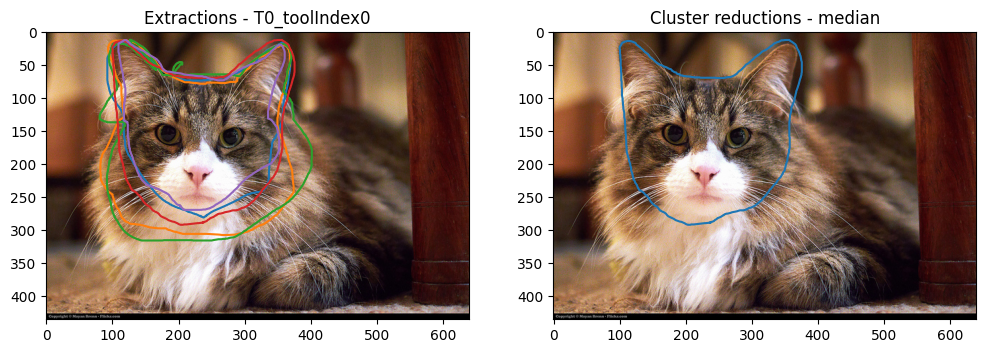

In [36]:
plot_image_and_reductions(
    unique_subject_ids[1],
    reductions_median,
    extractions,
    locations_list,
    tool='T0_toolIndex0',
    average_type='median'
);

On the left is the original extractions and on the right is the reduction, which seems to have worked! The `median` polygon appears to give a good representative of the drawings done by the volunteers. The data processing has been able to handle the non-closed drawings.

Note that if there were any self-intersections (the small green unclosed loop here does not in fact self-intersect), these will be processed into a list of simple-connected shapes and the largest one chosen for the reduction.

Now let's look at the case with the trickster volunteer.

consensus is
[0.8569853596733021]


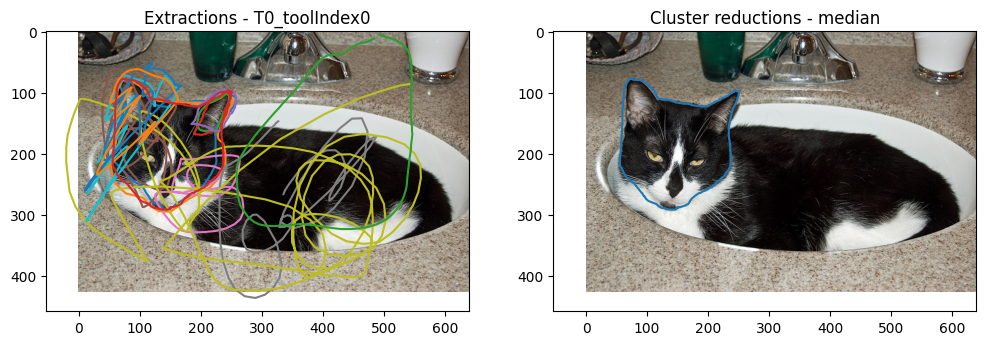

In [37]:
plot_image_and_reductions(
    unique_subject_ids[17],
    reductions_median,
    extractions,
    locations_list,
    tool='T0_toolIndex0',
    average_type='median'
)

The reduction was successful! It was able to remove all of the squiggles and leave just a reduction based on the non-trickster volunteers. Again, the `median` choice for `average_type` seems to give a sensible answer.

How do the other choices for `average_type` compare? We will only look here at `union` and `intersection`, as this project did not have a collaborative workflow, removing the main reason to use `last`.

consensus is
[0.7301441252946794]


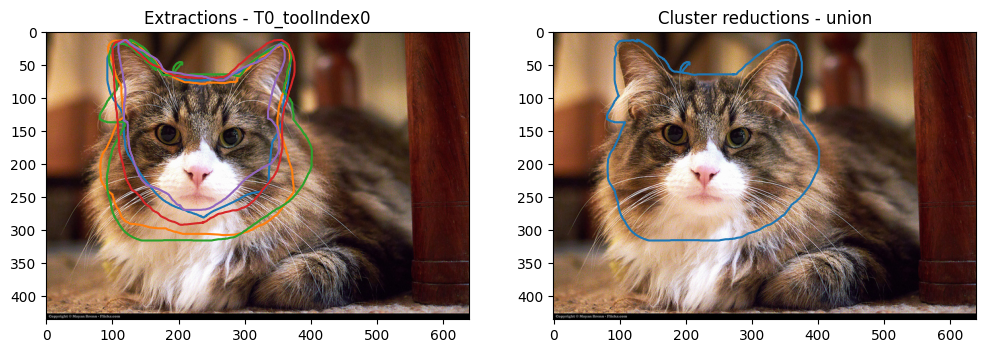

In [38]:
reducer_config = StringIO('''{
    'reducer_config': {'polygon_reducer': {
            'average_type': 'union',
            'eps': 0.5,
            'min_samples': 2
        }
    }
}''')

reduction_file_location = reduce_csv(
    extraction_file_location,
    reducer_config,
    output_dir=output_folder,
    output_name='reductions_union',
    hide_progressbar=True
)

reductions_union = pandas.read_csv(reduction_file_location);

plot_image_and_reductions(
    unique_subject_ids[1],
    reductions_union,
    extractions,
    locations_list,
    tool='T0_toolIndex0',
    average_type='union'
)

consensus is
[0.7301441252946794]


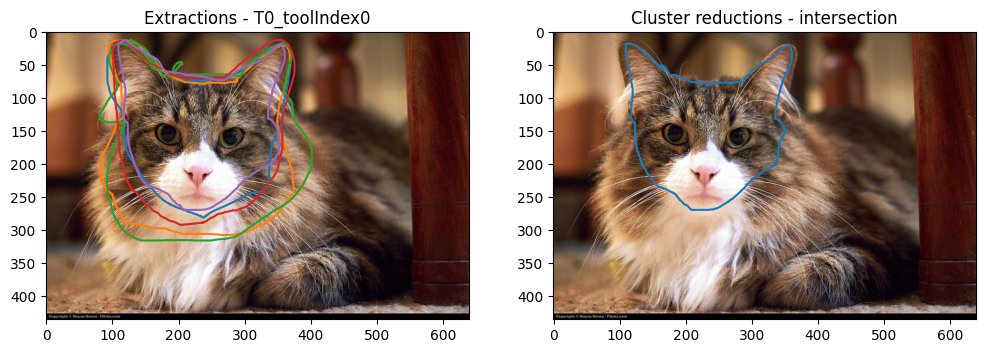

In [39]:
reducer_config = StringIO('''{
    'reducer_config': {'polygon_reducer': {
            'average_type': 'intersection',
            'eps': 0.5,
            'min_samples': 2
        }
    }
}''')

reduction_file_location = reduce_csv(
    extraction_file_location,
    reducer_config,
    output_dir=output_folder,
    output_name='reductions_intersection',
    hide_progressbar=True
)

reductions_intersection = pandas.read_csv(reduction_file_location);

plot_image_and_reductions(
    unique_subject_ids[1],
    reductions_intersection,
    extractions,
    locations_list,
    tool='T0_toolIndex0',
    average_type='intersection'
)

Both have worked as intended. The [union](_static/polygon_reducer_reductions_union.csv) and [union](_static/polygon_reducer_reductions_intersection.csv) reduction files are also available for download.

If you would like to run these reductions using the command line, change `median` option for `average_type` in the `.yaml` [file](_static/cat_project_reducer_config.yaml) to option you want, then use the command from before with name after the argument `-o` to reflect the `average_type` you are using. E.g. for the `union` choice of `average_type`, change the contents of the `.yaml` file to

```
reducer_config: 
    polygon_reducer:
        average_type: 'union'
        eps: 0.5
        min_samples: 2
```

and use the command

```panoptes_aggregation reduce _static/polygon_extractor_extractions.csv _static/cat_project_reducer_config.yaml -d _static/ -o reductions_union```

which assumes you have the command line open in the same directory as the `_static` folder exists.

### Contours and edge cases
The final investigation is to look at the contours of the volunteer classifications. This requires a separate reduction, which can be done in a similar manner to before but without needing to specify `average_type`. This is done using `panoptes_aggregation.reducers.polygon_reducer_contours`.

As each subject (photo here) can have multiple clusters (multiple cats), and each cluster will have a series of contours, this reduction has one *row per cluster*, rather than one row per subject as before.

Due to the additional computation to compute the contours already noted, this will take longer than the previous reductions, but should finish in under a minute.

In [40]:
reducer_config = StringIO('''{
    'reducer_config': {'polygon_reducer_contours': {
            'eps': 0.5,
            'min_samples': 2
        }
    }
}''')

reduction_contours_file_location = reduce_csv(
    extraction_file_location,
    reducer_config,
    output_dir=output_folder,
    output_name='reductions',
    hide_progressbar=True
)
reductions_contours = pandas.read_csv(reduction_contours_file_location)

The file is available [here](_static/polygon_reducer_contours_reductions.csv) to download.

We can also do this reduction using the command line and the [config file](_static/cat_project_reducer_contours_config.yaml) and the following command

`panoptes_aggregation reduce _static/polygon_extractor_extractions.csv _static/cat_project_reducer_contours_config.yaml -d _static/ -o reductions`

The `reductions_contours` file, as with the earlier reductions files, also contains lots of info about the reduction. E.g. what cluster each set of contours belong to, the consensus of the cluster, the number of contours in the cluster and the cluster labels for the whole subject and tool etc. These, along with other useful information, can again accessed using the keys.

Let's look at the first few lines of this file

In [68]:
reductions_contours.iloc[:4]

subject_id  workflow_id task                   reducer  \
0      458021        28090   T0  polygon_reducer_contours   
1      458022        28090   T0  polygon_reducer_contours   
2      458023        28090   T0  polygon_reducer_contours   
3      458023        28090   T0  polygon_reducer_contours   

  data.aggregation_version  \
0                    5.0.0   
1                    5.0.0   
2                    5.0.0   
3                    5.0.0   

   data.frame0.T0_toolIndex0_cluster_label_for_contours  \
0                                                0.0      
1                                                0.0      
2                                                NaN      
3                                                0.0      

   data.frame0.T0_toolIndex0_number_of_contours  \
0                                           2.0   
1                                           5.0   
2                                           NaN   
3                                           6.0   

                data.frame0.T0_toolIndex0_contours_x  \
0  [[462.18, 461.29, 460.4, 460.4, 457.72, 455.93...   
1  [[272.03, 265.83, 262.49, 258.67, 257.24, 255....   
2                                                NaN   
3  [[478.18, 478.74, 479.3, 480.42, 480.98, 480.9...   

                data.frame0.T0_toolIndex0_contours_y  \
0  [[199.71, 199.71, 200.6, 201.5, 203.28, 205.07...   
1  [[63.71, 63.71, 63.71, 63.71, 63.71, 63.71, 63...   
2                                                NaN   
3  [[223.66, 223.66, 223.66, 224.22, 224.22, 224....   

   data.frame0.T0_toolIndex0_consensus  \
0                             0.821362   
1                             0.730144   
2                                  NaN   
3                             0.646813   

            data.frame0.T0_toolIndex0_cluster_labels  \
0                                             [0, 0]   
1                                    [0, 0, 0, 0, 0]   
2                                                NaN   
3  [0, 1, -1, -1, -1, 1, -1, -1, 0, 1, 0, 0, 1, -...   

   data.parameters.min_samples  data.parameters.eps  \
0                            2                  0.5   
1                            2                  0.5   
2                            2                  0.5   
3                            2                  0.5   

  data.frame0.T0_toolIndex1_cluster_labels  \
0                                      NaN   
1                                      NaN   
2                                     [-1]   
3                                      NaN   

   data.frame0.T0_toolIndex1_cluster_label_for_contours  \
0                                                NaN      
1                                                NaN      
2                                                NaN      
3                                                NaN      

   data.frame0.T0_toolIndex1_number_of_contours  \
0                                           NaN   
1                                           NaN   
2                                           NaN   
3                                           NaN   

  data.frame0.T0_toolIndex1_contours_x data.frame0.T0_toolIndex1_contours_y  \
0                                  NaN                                  NaN   
1                                  NaN                                  NaN   
2                                  NaN                                  NaN   
3                                  NaN                                  NaN   

   data.frame0.T0_toolIndex1_consensus  
0                                  NaN  
1                                  NaN  
2                                  NaN  
3                                  NaN

This is similair to the previous `reductions` file we looked at, but it is *the contours of one cluster per row*, rather than one subject per row. This can be see as the 2nd and 3rd rows have the same subject IDs. The columns contain information about each cluster, along with the kwargs used to define the reduction.  

As the data is in a different format to the standard reduction, we will need a new function to plot them. This information is contained in the 'data.frame0.T0_toolIndex0_contours_x' and 'data.frame0.T0_toolIndex0_contours_y' columns. A function which plots the contours of these columns over the original subject image is defined below. Again, we will start with plotting the subject as before.

In [71]:
def plot_image_and_contours(subject_id, reductions, extractions, locations_list, tool='T0_toolIndex0'):
    # Plot the image first
    fig, ax = plt.subplots(figsize=(8,5))
    subject_id_list = list(set(extractions["subject_id"]))
    subject_id_list.sort()
    location = locations_list[subject_id_list.index(subject_id)]
    response = requests.get(location)
    img = Image.open(BytesIO(response.content))
    ax.imshow(img)

    # Parameters used to make the contours see through
    alpha_min = 0.15
    alpha_max = 0.45
    max_contours = 0
    
    # Now find the indices for this subject ID (there can be mutiple clusters per subject)
    reductions_subject_id_list = list(reductions["subject_id"])
    indices_reduction_file = []
    for i, value in enumerate(reductions_subject_id_list):
        if value==subject_id and isinstance(reductions[f'data.frame0.{tool}_contours_x'][i], str):
            indices_reduction_file.append(i)
            # Find the max number of contours
            max_contours = max(reductions[f'data.frame0.{tool}_number_of_contours'][i], max_contours)

    # Normalise the colour bar to the highest number of agreement
    cmap = colormaps.get_cmap('plasma')
    norm = colors.Normalize(vmin=1, vmax=max_contours)

    # Plot the contours
    for index in indices_reduction_file:
        contours_x = eval(reductions[f'data.frame0.{tool}_contours_x'][index])
        contours_y = eval(reductions[f'data.frame0.{tool}_contours_y'][index])
        for i in range(len(contours_x)):
            x = contours_x[i]
            y = contours_y[i]
            xy = np.array([x, y]).T
            contour = shapely.Polygon(xy)
            num_agreement = i+1
            color = cmap(norm(num_agreement))
            alpha = alpha_min + norm(num_agreement)*(alpha_max - alpha_min)
            plot_polygon_on_ax(ax, contour, facecolor=color, alpha=alpha)

    cax = ax.inset_axes([1.04, 0.0, 0.05, 1], transform=ax.transAxes)
    cb = colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical')
    cb.set_label('# agreement')

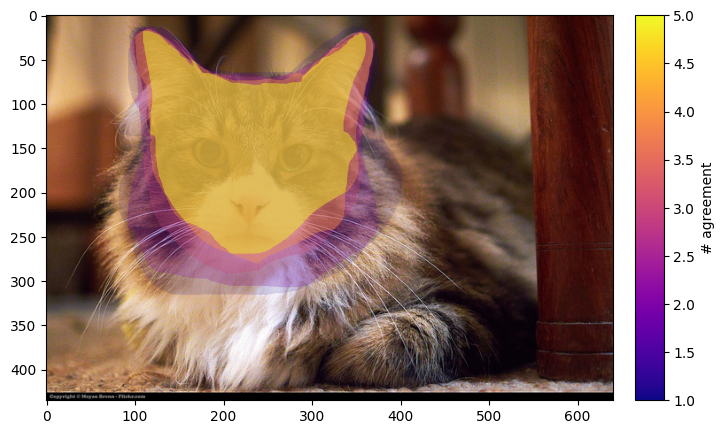

In [43]:
plot_image_and_contours(
    unique_subject_ids[1],
    reductions_contours,
    extractions,
    locations_list,
    tool='T0_toolIndex0'
)

We can see various coloured contours over the cat. The colour of the contour is the amount of agreement/overlap between the freehand drawings of our vlunteers.

This is useful for making clear the areas of uncertainty in what is defined as the 'cat's head and ears'. It also neatly contains th same information as both the `union` and `intersection` choices for `average_type`. The contour based reduction can also be used to find the region where a certain number of volunteers agree. We plot this region with the following function, where we are interested in the region where at least three volunteers agree.

This plot can also be done for cases with more than one cat as well, as the function below finds all of the clusters for the subject ID provided.

In [44]:
def plot_image_and_contour_level(subject_id, reductions, extractions, locations_list, contour_level=2, tool='T0_toolIndex0'):
    # Plot the image first
    fig, ax = plt.subplots(figsize=(8,5))
    subject_id_list = list(set(extractions["subject_id"]))
    subject_id_list.sort()
    location = locations_list[subject_id_list.index(subject_id)]
    response = requests.get(location)
    img = Image.open(BytesIO(response.content))
    ax.imshow(img)
    
    # Now find the indices for this subject ID (there can be mutiple clusters per subject)
    reductions_subject_id_list = list(reductions["subject_id"])
    indices_reduction_file = []
    for i, value in enumerate(reductions_subject_id_list):
        if value==subject_id and isinstance(reductions[f'data.frame0.{tool}_contours_x'][i], str):
            indices_reduction_file.append(i)

    # Plot the contour level as a polygon
    for index in indices_reduction_file:
        contours_x = eval(reductions[f'data.frame0.{tool}_contours_x'][index])
        contours_y = eval(reductions[f'data.frame0.{tool}_contours_y'][index])
        i = contour_level - 1
        x = contours_x[i]
        y = contours_y[i]
        ax.plot(x, y)

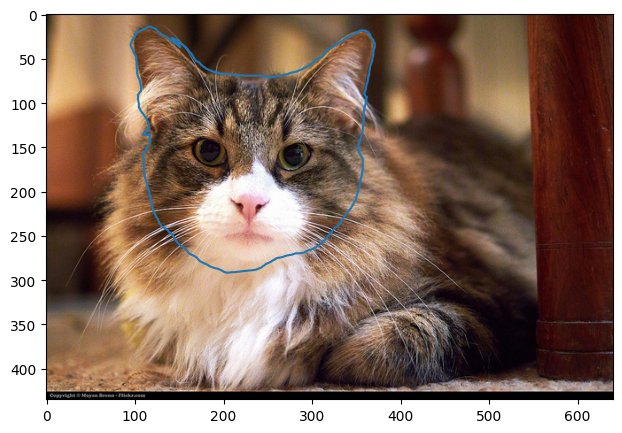

In [45]:
plot_image_and_contour_level(
    unique_subject_ids[1],
    reductions_contours,
    extractions,
    locations_list,
    contour_level=3,
    tool='T0_toolIndex0'
)

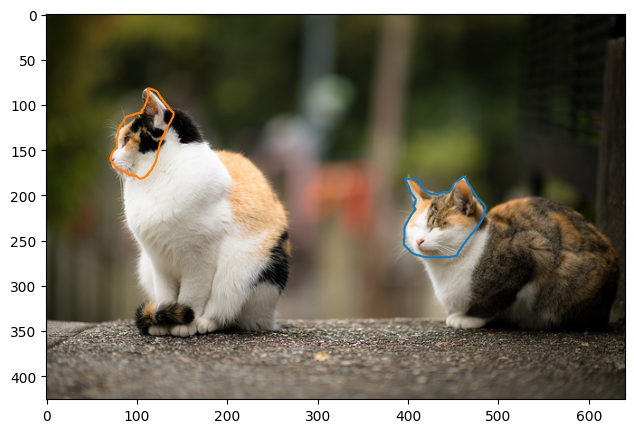

In [46]:
plot_image_and_contour_level(
    unique_subject_ids[23],
    reductions_contours,
    extractions,
    locations_list,
    contour_level=3,
    tool='T0_toolIndex0'
)

#### Edge case

Finally, we come to an edge case where there are two cats very close to each other.

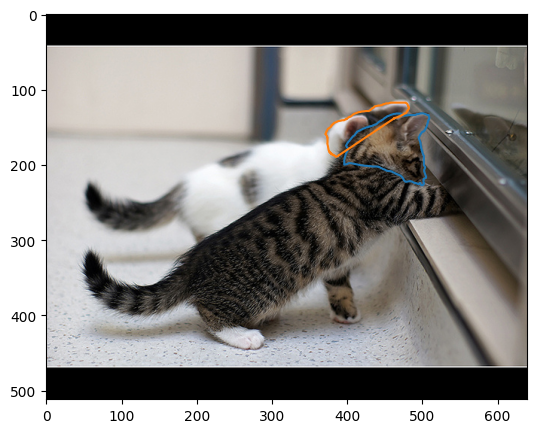

In [47]:
plot_image_and_contour_level(
    unique_subject_ids[2],
    reductions_contours,
    extractions,
    locations_list,
    contour_level=3,
    tool='T0_toolIndex0'
)

Well, two very cute kittens are close together! We can see that the two separate cats were identified when we used `eps`=0.5. But some of the volunteers actually classified them together as a single cat. This can be seen by plotting the contours:

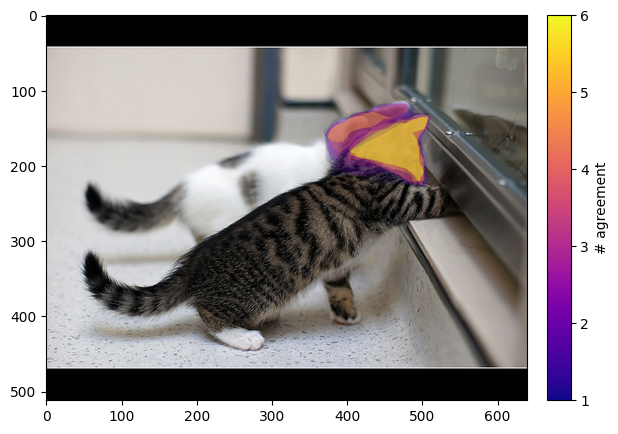

In [48]:
plot_image_and_contours(
    unique_subject_ids[2],
    reductions_contours,
    extractions,
    locations_list,
    tool='T0_toolIndex0'
)

Where the two regions overlap. Whether or not to separate the two regions will depend on the project these tools are being used for.

#### Ordering of contour reduction

If `polygon_reducer_contours` was computed with more than one CPU core, the ordering can differ to what is expected based on the order of the extractions. This can be reordered using the following command:

In [49]:
tool = 'T0_toolIndex0'

reductions_contours_sorted = reductions_contours.sort_values(
    by=['subject_id', f'data.frame0.{tool}_cluster_label_for_contours']
)

You can just replace the tool string with the tool you are interested in sorting by.

### Final note
Well done for getting to the end of this guide! I hope you enjoyed the cute cat photos.

If after going through this guide you still have questions about how to use the extractor and reducers for the polygon data, please feel free to reach out to contact@zooniverse.org, they are always happy to help!